Task 3 a)

In [28]:
def weighted_degree_kernel(s1,s2,d,betas):
    K= 0
    for k in range (1,d+1):
        I= 0
        beta = betas[k-1]
        for l in range (0,(len(s1)-k+1)):
            if (s1[l:l+k]==s2[l:l+k]):
                I = I+1
        K= K+ (beta * I)          
    return K


In [1]:
from Bio import SeqIO
from Bio.SeqRecord import SeqRecord
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Task 3 b)

In [29]:
sequences=[]
for seq_record in SeqIO.parse(r'sequencesMSAfasta.sec','fasta'):
    sequences.append(str(seq_record.seq))
#generate possible sequence combinations
s = list(range(0,len(sequences)))
combis= list(itertools.combinations_with_replacement(s, 2))
#init kernel_matrix
kernel_matrix=np.zeros((len(sequences),len(sequences)))
d= 3
betas = np.array([2*(d-k+1)/(d*(d+1)) for k in range(1,d+1)])
#fill kernel matrix
for i in range (len(combis)):
    s1= sequences[combis[i][0]]
    s2= sequences[combis[i][1]]
    kernel_matrix[combis[i][0]][combis[i][1]]= weighted_degree_kernel(s1,s2,d,betas)
    kernel_matrix[combis[i][1]][combis[i][0]]= kernel_matrix[combis[i][0]][combis[i][1]]

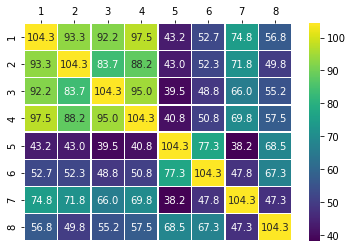

In [30]:
kernel_matrix= pd.DataFrame(kernel_matrix,columns=[1,2,3,4,5,6,7,8])
kernel_matrix.index= [1,2,3,4,5,6,7,8]
ax = sns.heatmap(kernel_matrix, cmap='viridis',annot=True,fmt=".1f",linewidth=.5)
ax.set(xlabel="", ylabel="")
ax.xaxis.tick_top()
plt.savefig('kernel_matrix.png', dpi=600)

Task 4 a)

In [14]:
def dirac(a1, a2):
    K = 0
    if a1 == a2:
        K = 1            
    return K

def uniform(a1, a2):
    return 1

def multitask(a1, a2):
    K = dirac(a1, a2) + uniform(a1, a2)
    return K

def peptide(p1,p2):
    K= 0
    for l in range (len(p1)):
        if (p1[l]==p2[l]):
                K = K+1         
    return K

Task 4 b)

In [3]:
from sklearn.model_selection import ShuffleSplit
from sklearn.svm import SVC
from itertools import combinations

In [4]:
binding_data= pd.read_csv('BindingData.csv', delimiter=',')
binding_data_Y= binding_data[' binding label']

In [5]:
def kernel_combination (allele_kernel, peptide_kernel,a1,a2,p1,p2):
    a = allele_kernel(a1,a2)
    p = peptide_kernel(p1,p2)
    K = a*p
    return K

In [6]:
def precomputed_kernel_GridSearchCV(K, y, Cs, n_splits=10, test_size=0.2, random_state=42):
    """A version of grid search CV, 
    but adapted for SVM with a precomputed kernel
    K (np.ndarray) : precomputed kernel
    y (np.array) : labels
    Cs (iterable) : list of values of C to try
    return: optimal value of C and best score 
    """
    n = K.shape[0]
    assert len(K.shape) == 2
    assert K.shape[1] == n
    assert len(y) == n
    
    best_score = float('-inf')
    best_C = None
 
    indices = np.arange(n)
    
    for C in Cs:
        # for each value of parameter, do K-fold
        # The performance measure reported by k-fold cross-validation 
        # is the average of the values computed in the loop
        scores = []
        ss = ShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=random_state)
        for train_index, test_index in ss.split(indices):
            K_train = K[np.ix_(train_index,train_index)]
            K_test = K[np.ix_(test_index, train_index)]
            y_train = y[train_index]
            y_test = y[test_index]
            svc = SVC(kernel='precomputed', C=C)
            svc.fit(K_train, y_train)
            scores.append(svc.score(K_test, y_test))
        if np.mean(scores) > best_score:
            best_score = np.mean(scores)
            best_C = C
    return best_C,best_score

In [7]:
def predefined_kernel_matrix (allele_kernel,peptide_kernel,data):
    K_comb= np.zeros((len(data),len(data)))
    indexes = data.index.values.tolist()
    combinations= list(itertools.combinations_with_replacement(indexes, 2))
    for i in range (len(combinations)):
        K_comb[combinations[i][0]][combinations[i][1]]= kernel_combination(allele_kernel,peptide_kernel,data[' allele'][combinations[i][0]], data[' allele'][combinations[i][1]],data[' peptide sequence'][combinations[i][0]], data[' peptide sequence'][combinations[i][1]])
        K_comb[combinations[i][1]][combinations[i][0]]= K_comb[combinations[i][0]][combinations[i][1]]
    
    return K_comb

In [8]:
C=[10**(-4),10**(-3),10**(-2),10**(-1), 10**0, 10**1, 10**2]

In [9]:
dirac_best_C,dirac_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(dirac,peptide,binding_data),binding_data_Y, C)

In [10]:
dirac_best_C,dirac_best_score

(0.1, 0.6223076923076922)

In [11]:
uniform_best_C,uniform_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(uniform,peptide,binding_data),binding_data_Y, C)

In [12]:
uniform_best_C,uniform_best_score

(0.1, 0.6188461538461538)

In [15]:
multitask_best_C,multitask_best_score= precomputed_kernel_GridSearchCV(predefined_kernel_matrix(multitask,peptide,binding_data),binding_data_Y, C)

In [16]:
multitask_best_C,multitask_best_score

(0.1, 0.6188461538461538)

Task 4 c)

In [18]:
supertype= pd.read_csv('supertype.csv', delimiter=',')

,Supertype,Motif,Genotypes
0,A1,x[TI(SVLM)]xxxxxx[WFY],"A*0101, A*0102, A*2501, A*2601, A*2604, A*3201..."
1,A2,x[LIVMATQ]xxxxxx[LIVMAT],"A*0201, A*0202, A*0203, A*0204, A*0205, A*0206..."
2,A3,x[AILMVST]xxxxxx[RK],"A*0301, A*1101, A*3101, A*3301, A*6801"
3,A24,x[YF(WIVLMT)]xxxxxx[FI(YWLM)],"A*2301, A*2402, A*2403, A*2404, A*3001, A*3002..."
4,B7,x[P]xxxxxx[ALIMVFWY],"B*0702, B*0703, B*0704, B*0705, B*1508, B*3501..."
5,B27,x[RKH]xxxxxx[FLY(WMI)],"B*1401, B*1402, B*1503, B*1509, B*1510, B*1518..."
6,B44,x[E(D)]xxxxxx[FWYLIMVA],"B*18, B*3701, B*4001, B*4006, B*4101, B*4402, ..."
7,B58,x[AST]xxxxxx[FWY(LIV)],"B*1516, B*1517, B*5701, B*5702, B*58"
8,B62,x[QL(IVMP)]xxxxxx[FWY(MIV)],"B*1301, B*1302, B*1501, B*1502, B*1506, B*1512..."


In [19]:
def supertype_dirac(a1, a2):
    K = 0
    if a1 == a2:
        K = 1            
    return K

def supertype_multitask(a1, a2):
    K = supertype_dirac(a1, a2) + uniform(a1, a2)
    return K

Task d) 

Task e) 